In [75]:
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle


def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus),
                  "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


solve_cudnn_error()

# %matplotlib inline
# def W_init(shape, dtype=None):
#     """Initialize weights as in paper"""
#     values = rng.normal(loc=0, scale=1e-2, size=shape)
#     return K.variable(values, dtype=dtype)

# #//TODO: figure out how to initialize layer biases in keras.
# def b_init(shape, dtype=None):
#     """Initialize bias as in paper"""
#     values = rng.normal(loc=0.5, scale=1e-2, size=shape)
#     return K.variable(values, dtype=dtype)

input_shape = (96, 96, 3 )
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(
    Conv2D(64, (7, 7),
           activation='relu',
           input_shape=input_shape,
           kernel_initializer=initializers.RandomNormal(stddev=0.01),
           #kernel_constraint=initializers.RandomNormal(mean=0.5),
           kernel_regularizer=l2(2e-4))),
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128, (7, 7), activation='relu',
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),
                   #kernel_constraint=initializers.RandomNormal(mean=0.5),
                   kernel_regularizer=l2(2e-4))),
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128, (4, 4), activation='relu',
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),
                   #kernel_constraint=initializers.RandomNormal(mean=0.5),
                   kernel_regularizer=l2(2e-4))),
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256, (4, 4), activation='relu',
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),
                   #kernel_constraint=initializers.RandomNormal(mean=0.5),
                   kernel_regularizer=l2(2e-4))),
convnet.add(MaxPooling2D())
convnet.add(Conv2D(512, (2, 2), activation='relu',
                   kernel_initializer=initializers.RandomNormal(stddev=0.01),
                   #kernel_constraint=initializers.RandomNormal(mean=0.5),
                   kernel_regularizer=l2(2e-4))),
convnet.add(Flatten())
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer = Adam(0.0001)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)

siamese_net.count_params()

1 Physical GPUs, 1 Logical GPUs


3827969

In [69]:
convnet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 90, 90, 64)        9472      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 39, 39, 128)       401536    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 5, 5, 256)        

## Data 
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [70]:
PATH = "../../../data_set/模型訓練資料/save/"  #CHANGE THIS - path where the pickled data is stored

with open(os.path.join(PATH, "x_train.pickle"), "rb") as f:
    (X, c, l) = pickle.load(f)
    
# with open(os.path.join(PATH, "x_val.pickle"), "rb") as f:
#     (Xval, cval, lval) = pickle.load(f)

#print("training alphabets")
#print(c)

In [71]:
# rescale (1/255.)
for i in range(X.shape[0]) :
    X[i] = X[i] * (1/255.)

In [72]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, data_subsets=["train", "val"]):
        self.data = {}
        self.label = {}
        self.categories = {}
        self.lang_dict = {}
        self.info = {}
        self.n_class = 0
        # loading the data
        for name in data_subsets:
            file_path = os.path.join(path, "x_" + name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path, "rb") as f:
                (X, c, l) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c
                self.lang_dict[name] = l
        # loading the label
        for name in data_subsets:
            file_path = os.path.join(path, "y_" + name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path, "rb") as f:
                y = pickle.load(f)
                self.label[name] = y

    def get_batch(self, batch_size, s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X = self.data[s]
        y = self.label[s]
        l = self.lang_dict[s]
        c = self.categories[s]
        all_samples, w, h, chanel = X.shape
        n_classes = len(c)
        #randomly sample several classes to use in the batch
        categories_temp = rng.choice(n_classes,
                                     size=(batch_size, ),
                                     replace=False)
        #initialize 2 empty arrays for the input image batch

        #pairs=[np.zeros((batch_size, w, h,chanel)) for i in range(2)]
        pairs0 = []
        pairs1 = []
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets = np.zeros((batch_size, ))
        targets[batch_size // 2:] = 1
        for i in range(batch_size):
            category = categories_temp[i]
            # find the num of examples of the class
            idx_1 = rng.randint(l[c[category][0]][0], l[c[category][0]][1])
            pairs0.append(X[idx_1])
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category
            else:
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = rng.randint(n_classes)

            idx_2 = rng.randint(l[c[category_2][0]][0], l[c[category_2][0]][1])
            pairs1.append(X[idx_2])

        pairs0 = np.stack(pairs0)
        pairs1 = np.stack(pairs1)
        pairs = [pairs0, pairs1]
        return pairs, targets

    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size, s)
            yield (pairs, targets)

    def make_oneshot_task(self, N, s="val", words=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X = self.data[s]
        y = self.label[s]
        l = self.lang_dict[s]
        c = self.categories[s]
        all_samples, w, h, chanel = X.shape

        if s == 'val':
            n_classes_low = list(loader.categories['val'].keys())[0]
            n_classes_high = list(loader.categories['val'].keys())[-1]
        else:
            n_classes = len(c)

        #indices = rng.randint(0,n_examples,size=(N,))
        if words is not None:
            low, high = l[words]
            if N > high - low:
                raise ValueError(
                    "This language ({}) has less than {} letters".format(
                        words, N))
            categories = rng.choice(range(low, high), size=(N, ))

        else:  #if no language specified just pick a bunch of random letters
            if s == 'val':
                categories = rng.choice(range(n_classes_low, n_classes_high),
                                        size=(N, ),
                                        replace=False)
            else:
                categories = rng.choice(range(n_classes),
                                        size=(N, ),
                                        replace=False)
        true_category = categories[0]
        ex1 = rng.randint(l[c[true_category][0]][0], l[c[true_category][0]][1])
        ex2 = rng.randint(l[c[true_category][0]][0], l[c[true_category][0]][1])
        test_image = np.asarray([X[ex1]] * N).reshape(N, w, h, 3)

        # build the support set
        support_set = []
        for category in categories:
            #idx = rng.randint(l[c[category][0]][0], l[c[category][0]][1])
            idx = l[c[category][0]][0]+1
            support_set.append(X[idx])
        support_set = np.stack(support_set)
        support_set[0] = X[ex2]
        #        support_set = support_set.reshape(N, w, h,3)
        targets = np.zeros((N, ))
        targets[0] = 1
        #targets, test_image, support_set = (targets, test_image,
        #                                           support_set)
        pairs = [test_image, support_set]

        return pairs, targets

    def test_oneshot(self, model, N, k, s="val", verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print(
                "Evaluating model on {} random {} way one-shot learning tasks ..."
                .format(k, N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N, s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        percent_correct = (100.0 * n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".
                  format(percent_correct, N))
        return percent_correct

    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size), )


#Instantiate the class
loader = Siamese_Loader(PATH)

loading data from ../../../data_set/模型訓練資料/save/x_train.pickle
loading data from ../../../data_set/模型訓練資料/save/x_val.pickle
loading data from ../../../data_set/模型訓練資料/save/y_train.pickle
loading data from ../../../data_set/模型訓練資料/save/y_val.pickle


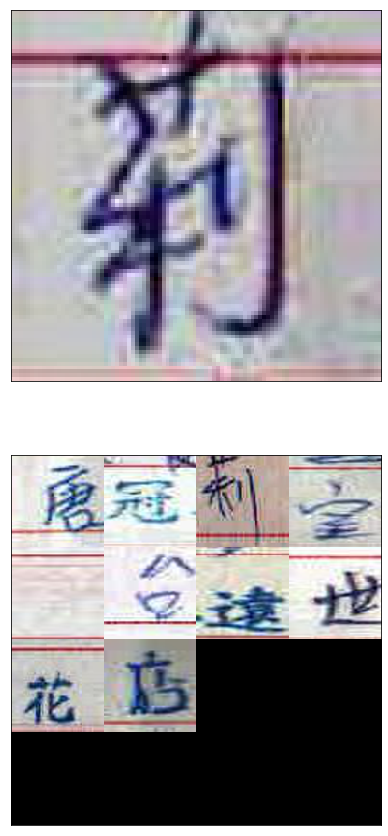

In [73]:
# i just concat the images into same shape in the data loader
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    N, h, w, chanel = X.shape
    X = X.reshape(N, h, w, chanel)
    n = int(np.ceil(np.sqrt(N)))
    img = np.zeros((n * w, n * h, 3))
    x = 0
    y = 0
    for example in range(N):
        img[x * w:(x + 1) * w, y * h:(y + 1) * h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 15))
    ax1.matshow(pairs[0][0], cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img.astype('uint8'), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()


#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(10, "train")
plot_oneshot_task(pairs)

In [74]:
#Training loop
print("!")
evaluate_every = 1  # interval for evaluating on one-shot tasks
loss_every = 50  # interval for printing loss (iterations)
batch_size = 32
n_iter = 10000
N_way = 10  # how many classes for testing one-shot tasks>
n_val = 10 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights")
print("training")
for i in range(1, n_iter):
    (inputs, targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net, N_way, n_val,s='train',verbose=True)
        if val_acc > best:
            print("saving")
            siamese_net.save(weights_path)
            best = val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i, loss))

!
training


TypeError: in user code:

    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:498 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:635 apply_gradients
        "name": name,
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2941 merge_call
        return self._merge_call(merge_fn, args, kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2948 _merge_call
        return merge_fn(self._strategy, *args, **kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:683 _distributed_apply  **
        var, apply_grad_to_update_var, args=(grad,), group=False))
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2494 update
        return self._update(var, fn, args, kwargs, group)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3431 _update
        return self._update_non_slot(var, fn, (var,) + tuple(args), kwargs, group)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3437 _update_non_slot
        result = fn(*args, **kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:661 apply_grad_to_update_var  **
        return var.assign(var.constraint(var))
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\keras\initializers\initializers_v2.py:305 __call__
        shape, dtype=_get_dtype(dtype), **kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops_v2.py:420 __call__
        dtype)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops_v2.py:1073 random_normal
        shape=shape, mean=mean, stddev=stddev, dtype=dtype, seed=self.seed)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\random_ops.py:95 random_normal
        shape_tensor, dtype, seed=seed1, seed2=seed2)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_random_ops.py:654 random_standard_normal
        seed2=seed2, name=name)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:630 _apply_op_helper
        param_name=input_name)
    C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:63 _SatisfiesTypeConstraint
        ", ".join(dtypes.as_dtype(x).name for x in allowed_list)))

    TypeError: Value passed to parameter 'shape' has DataType float32 not in list of allowed values: int32, int64


Evaluating model on 5 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 5 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 1 way one-shot learning tasks ...
Evaluating model on 5 random 6 way one-shot learning tasks ...


C:\Users\USER\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Got an average of 20.0% 6 way one-shot learning accuracy
Evaluating model on 5 random 6 way one-shot learning tasks ...
Got an average of 0.0% 6 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 6 way one-shot learning tasks ...
Evaluating model on 5 random 11 way one-shot learning tasks ...
Got an average of 0.0% 11 way one-shot learning accuracy
Evaluating model on 5 random 11 way one-shot learning tasks ...
Got an average of 0.0% 11 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 11 way one-shot learning tasks ...
Evaluating model on 5 random 16 way one-shot learning tasks ...
Got an average of 20.0% 16 way one-shot learning accuracy
Evaluating model on 5 random 16 way one-shot learning tasks ...
Got an average of 20.0% 16 way one-shot learning accuracy
Evaluating nearest neighbour on 5 unique 16 way one-shot learning tasks ...
Evaluating model on 5 random 21 way one-shot learning tasks ...
Got an average of 0.0% 21 way one-shot learning

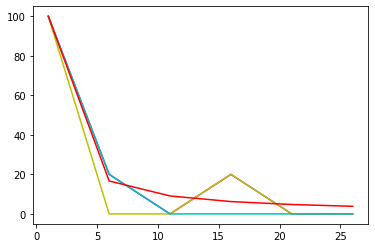

In [56]:
def nearest_neighbour_correct(pairs, targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways, n_trials, loader):
    """Returns accuracy of one shot """
    print(
        "Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ..."
        .format(n_trials, N_ways))

    n_right = 0

    for i in range(n_trials):
        pairs, targets = loader.make_oneshot_task(N_ways, "train")
        correct = nearest_neighbour_correct(pairs, targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 5)
resume = False
val_accs, train_accs, nn_accs = [], [], []
trials = 5
for N in ways:
    val_accs.append(
        loader.test_oneshot(siamese_net, N, trials, "train", verbose=True))
    train_accs.append(
        loader.test_oneshot(siamese_net, N, trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N, trials, loader))

#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways, 100.0 / ways, "r")
plt.show()

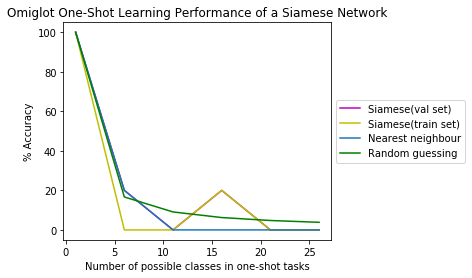

(800, 96, 96, 3)


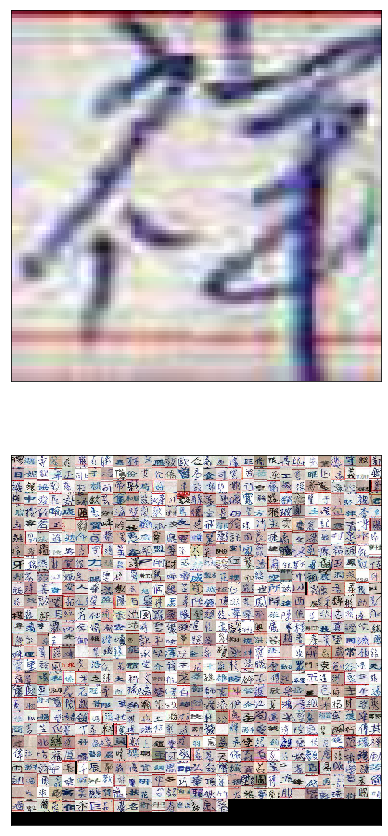

[[0.5035487 ]
 [0.50380486]
 [0.5058638 ]
 [0.50381845]
 [0.50443107]
 [0.5020625 ]
 [0.50217277]
 [0.50168836]
 [0.50418574]
 [0.50286657]
 [0.50224763]
 [0.50388354]
 [0.502207  ]
 [0.5021823 ]
 [0.5028523 ]
 [0.5061782 ]
 [0.50507474]
 [0.5025237 ]
 [0.50389326]
 [0.5042839 ]
 [0.5026353 ]
 [0.50351125]
 [0.5015702 ]
 [0.5024369 ]
 [0.50401723]
 [0.5039437 ]
 [0.50582504]
 [0.50510174]
 [0.50233483]
 [0.5045602 ]
 [0.5027694 ]
 [0.50214976]
 [0.50194633]
 [0.50194365]
 [0.50451463]
 [0.50314516]
 [0.50356483]
 [0.50162655]
 [0.50258315]
 [0.50147074]
 [0.50228906]
 [0.50209606]
 [0.5076057 ]
 [0.5036004 ]
 [0.5044438 ]
 [0.5029056 ]
 [0.5030423 ]
 [0.5026388 ]
 [0.5037699 ]
 [0.5022253 ]
 [0.5037091 ]
 [0.50359255]
 [0.50560325]
 [0.503197  ]
 [0.501789  ]
 [0.5013455 ]
 [0.50270563]
 [0.5036524 ]
 [0.5044624 ]
 [0.50690156]
 [0.50257045]
 [0.5025543 ]
 [0.5031735 ]
 [0.50456333]
 [0.5058511 ]
 [0.5029697 ]
 [0.5060807 ]
 [0.50478876]
 [0.5030582 ]
 [0.50248283]
 [0.5032896 ]
 [0.50

In [57]:
fig, ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0 / ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs, targets = loader.make_oneshot_task(800, "train")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p = siamese_net.predict(inputs)
print(p)

In [18]:
from PIL import Image

In [99]:
pairs,target = loader.get_batch(16)

In [169]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [170]:
data_gen_train = ImageDataGenerator(rescale=1/255.)

In [172]:
train_generator = data_gen_train.flow_from_directory('../../../data_set/模型訓練資料/format_train/', target_size=(128,128), batch_size=128)

Found 68804 images belonging to 800 classes.


In [176]:
train_generator

In [214]:
train_generator

AttributeError: 'tuple' object has no attribute 'shape'